In [88]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [137]:
df = yf.download(tickers="TSLA", period="7d", interval="1m")[["Open", "High", "Low", "Close"]]
print(df.head())

[*********************100%***********************]  1 of 1 completed
                           Open        High         Low       Close
Datetime                                                           
2023-10-23 09:30:00  210.000000  210.479996  208.820007  209.529999
2023-10-23 09:31:00  209.130005  209.770004  208.220001  208.479996
2023-10-23 09:32:00  208.380997  208.500000  207.550003  208.070007
2023-10-23 09:33:00  208.029999  208.059998  206.679993  206.789902
2023-10-23 09:34:00  206.755005  207.212296  206.010101  206.289993


In [138]:
X = df.index.values
y = df['Close'].values# The split point is the 10% of the dataframe length
offset = 30          # Number of candles in a day

X_train = X[:-offset]
y_train = y[:-offset]
X_test  = X[-offset:]
y_test  = y[-offset:]

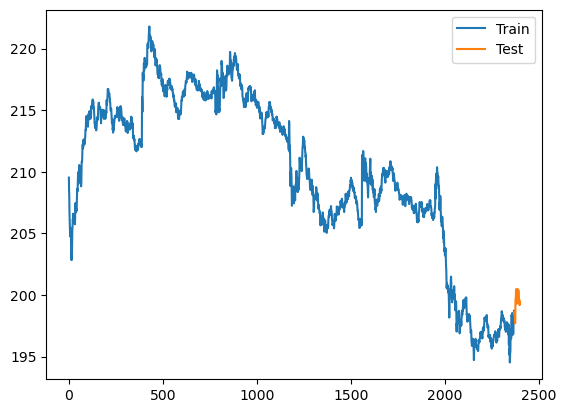

In [139]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(y_train)),y_train, label='Train')
plt.plot(range(len(y_train),len(y)),y_test,label='Test')
plt.legend()
plt.show()

In [140]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(5,0,1)).fit()
forecast = model.forecast(steps=offset)[0]

In [141]:
arima_pred = model.forecast(steps=offset)

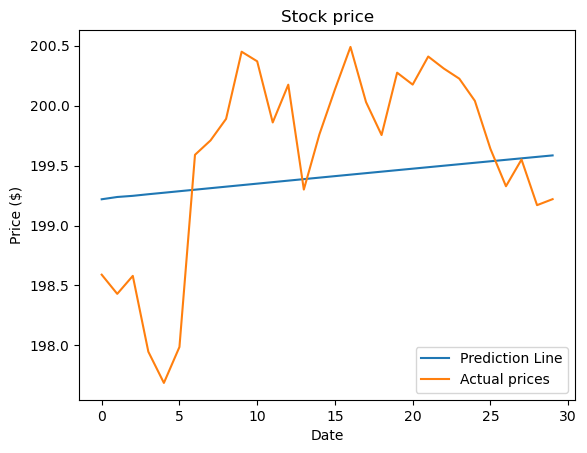

In [142]:
# Visualize the predictions
# demo.plot(forecast[:3300])
plt.plot(arima_pred, label="Prediction Line")
plt.plot(y_test, label="Actual prices")
plt.legend()
plt.title("Stock price")

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()


arima_pred = pd.DataFrame(arima_pred, index=X_test, columns=['Close'])
y_test = pd.DataFrame(y_test, index=X_test, columns=['Close'])

FB Prophet

In [143]:
data = df.copy()
data['ds'] = data.index
data.rename(columns={'Close':'y'}, inplace=True)

train = data[:-offset]
test = data[-offset:]

In [144]:
# Create a Prophet object and fit it to the data
from prophet import Prophet

demo = Prophet(daily_seasonality=True)
demo.add_regressor('High', standardize=False)
demo.add_regressor('Low', standardize=False)
demo.add_regressor('Open', standardize=False)
demo.fit(train)

10:31:09 - cmdstanpy - INFO - Chain [1] start processing
10:31:15 - cmdstanpy - INFO - Chain [1] done processing


In [145]:
# Make predictions for the future dates

forecast = demo.predict(test[['ds', 'High', 'Low', 'Open']])
prophet_pred = forecast.set_index(forecast['ds'])

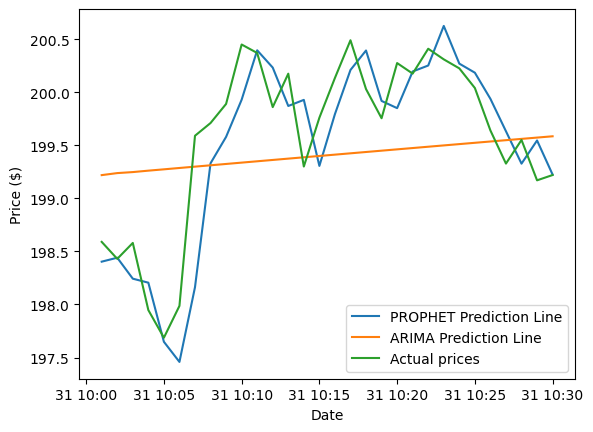

In [146]:
# Visualize the predictions
# demo.plot(forecast[-100:])
plt.plot(prophet_pred['yhat'], label="PROPHET Prediction Line")
plt.plot(arima_pred, label="ARIMA Prediction Line")
plt.plot(test['y'], label="Actual prices")

plt.legend()
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

In [147]:
import numpy as np

print("OC-Range: ", (df["Close"].iloc[-1]-df["Close"].iloc[0])/df["Close"].iloc[0])
print("HL-Range: ", (np.max(df["Close"])-np.min(df["Close"]))/np.min(df["Close"]))

OC-Range:  -0.04920535302180536
HL-Range:  0.14025241701105745


In [148]:
print("RMSE of ARIMA is: ", np.sqrt(np.mean(np.array(arima_pred-y_test)**2)))
print("MAE of ARIMA is: ", mean_absolute_error(y_test, arima_pred))

RMSE of ARIMA is:  0.7570594056016272
MAE of ARIMA is:  0.6569226771085084


In [149]:
print("RMSE of Prophet is: ", np.sqrt(np.mean(np.array(prophet_pred['yhat']-test['y'])**2)))
print("MAE of Prophet is: ", mean_absolute_error(test['y'], prophet_pred['yhat']))

RMSE of Prophet is:  0.4053831624915484
MAE of Prophet is:  0.3080371653375257
